## XGBOOST Approach

## 1. Package Installation

In [2]:
import numpy as np
import pandas as pd
import tqdm
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit, RepeatedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK

from Preprocessing import preprocessor

import warnings

warnings.filterwarnings("ignore")
%config InlineBackend.figure_format='retina'

## 2. Read In Data

In [3]:
df_wine = pd.read_csv('data/df_wine_ready.csv')
df_wine = df_wine.iloc[:,1:]
df_wine.head()

,normalized rating,price,positive,neutral,negative,compound,0,1,2,3,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,4.15,0.128299,-0.810436,0.960002,-0.449336,-0.826123,-0.171051,-0.204186,-0.131139,3.833288,...,-0.258417,-0.296863,-0.332,-0.340314,-0.386675,2.664482,-0.364692,-0.284207,-0.168551,-0.009596
1,4.15,-0.599151,-0.041276,0.189796,-0.449336,-0.197066,-0.171051,-0.204186,-0.131139,-0.203453,...,-0.258417,-0.296863,-0.332,2.938463,-0.386675,-0.375307,-0.364692,-0.284207,-0.168551,-0.009596
2,4.15,-0.628843,-1.359328,1.047161,0.950410,-1.363137,-0.171051,-0.204186,-0.131139,-0.203453,...,-0.258417,-0.296863,-0.332,-0.340314,-0.386675,2.664482,-0.364692,-0.284207,-0.168551,-0.009596
3,4.15,-0.658535,-0.810436,0.960002,-0.449336,-0.405175,-0.171051,-0.204186,-0.131139,-0.203453,...,-0.258417,-0.296863,-0.332,-0.340314,-0.386675,2.664482,-0.364692,-0.284207,-0.168551,-0.009596
4,4.15,0.885442,0.537814,-0.390081,-0.449336,1.260598,-0.171051,-0.204186,-0.131139,-0.203453,...,-0.258417,-0.296863,-0.332,-0.340314,2.586152,-0.375307,-0.364692,-0.284207,-0.168551,-0.009596


In [3]:
df_wine.shape

(119459, 400)

## 3. Apply XGBOOST Regression Model

### 3.1 Prepare Data Frame

In [ ]:
numeric_feature = ['normalized rating', 'price', 'positive', 'neutral', 'negative', 'compound']
df_numeric_feature = pd.concat([df_wine[numeric_feature], df_wine.iloc[:,20:]], axis=1)
df_numeric_feature.head()

In [ ]:
df_numeric_feature.to_csv('numeric_feature.csv')

In [ ]:
categorical_feature = ['country', 'continent', 'designation', 'province', 'region_1', 'region_2', 'variety', 'winery', 'polarity','year']
df_categorical_feature = df_wine[categorical_feature].astype('category')
df_categorical_feature.head()

In [ ]:
df_categorical_feature.to_csv('categorical_feature.csv')

In [ ]:
ohe = OneHotEncoder()
transformed = ohe.fit_transform(df_categorical_feature[['country', 'continent', 'polarity', 'year', 'variety']])
df_ohe = pd.DataFrame(transformed.toarray())
col_name = []
for i in ohe.categories_:
    col_name.extend(list(i))
df_ohe.columns = col_name
df_ohe.head()

### 3.2 Baseline Model

In [ ]:
X, y = df_wine.iloc[:, 1:], df_wine.iloc[:, 0]

In [ ]:
model_xgb = xgb.XGBRegressor(objective ='reg:squarederror', tree_method = 'gpu_hist')

In [ ]:
%%time
cv = ShuffleSplit(n_splits=5, test_size=0.2)
scores = cross_val_score(model_xgb, X, y, cv=cv, scoring='neg_root_mean_squared_error')
print(f'The model has a mean RMSE: {-np.mean(scores)}, with standard deviation: {np.std(scores)}')

### 3.3 Randomized Hyperopt

In [ ]:
def model(params):
    temp = df_wine.sample(frac=0.2)
    X, y = temp.iloc[:, 1:], temp.iloc[:, 0]

    model_xgb = xgb.XGBRegressor(n_estimators=params['n_estimators'],
                                 eta=params['eta'],
                                 max_depth=params['max_depth'],
                                 min_child_weight=params['min_child_weight'],
                                 subsample=params['subsample'],
                                 gamma=params['gamma'],
                                 colsample_bytree=params['colsample_bytree'],
                                 objective='reg:squarederror',
                                 tree_method='gpu_hist')
    cv = ShuffleSplit(n_splits=3, test_size=0.3)
    scores = cross_val_score(model_xgb, X, y, cv=cv, scoring='neg_root_mean_squared_error')
    return {'loss': -np.mean(scores), 'status': STATUS_OK, 'model': model_xgb}

In [ ]:
space = {
        'n_estimators': hp.choice('n_estimators', range(100, 5001, 100)),
        'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
        'max_depth':  hp.choice('max_depth', range(1, 11)),
        'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
        'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05)}

hypopt_trials = Trials()
best_params = fmin(model, space, algo=tpe.suggest, max_evals=1000, trials=hypopt_trials)
print(best_params)
print(hypopt_trials.best_trial['result']['loss'])

### 3.4 Best Model

In [ ]:
model_xgb = xgb.XGBRegressor(n_estimators=1500,
                             eta=0.05,
                             max_depth=5,
                             min_child_weight=6,
                             subsample=0.6,
                             gamma=0.5,
                             colsample_bytree=0.7,
                             objective='reg:squarederror',
                             tree_method='gpu_hist')

In [ ]:
X, y = df_wine.iloc[:, 1:], df_wine.iloc[:, 0]

In [ ]:
%%time
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
scores = cross_val_score(model_xgb, X, y, cv=cv, scoring='neg_root_mean_squared_error')
print(f'The model has a mean RMSE: {-np.mean(scores)}, with standard deviation: {np.std(scores)}')

In [ ]:
model_xgb.fit(X, y)
model_xgb.save_model('models/XGBOOST/XGBRegressor_0.773676.json')

In [ ]:
model_xgb = xgb.XGBRegressor()
model_xgb.load_model('models/XGBOOST/XGBRegressor_0.773676.json')

In [ ]:
xgb.plot_importance(model_xgb, max_num_features=30)

## 4. Apply Feature Selection

In [ ]:
thresholds = np.sort(model_xgb.feature_importances_)
thresholds = thresholds[thresholds > 0]
best_rmse = 9999
best_thresh = -1
best_n = -1
for thresh in tqdm.tqdm(thresholds):
    X, y = df_wine.iloc[:, 1:], df_wine.iloc[:, 0]
    selection = SelectFromModel(model_xgb, threshold=thresh, prefit=True)
    select_X = selection.transform(X)
    selection_model = xgb.XGBRegressor(n_estimators=1900,
                                       eta=0.05,
                                       max_depth=7,
                                       min_child_weight=9,
                                       subsample=0.75,
                                       gamma=0.7,
                                       colsample_bytree=0.85,
                                       objective='reg:squarederror',
                                       tree_method='gpu_hist')
    cv = ShuffleSplit(n_splits=5, test_size=0.2)
    scores = cross_val_score(selection_model, select_X, y, cv=cv, scoring='neg_root_mean_squared_error')
    if -np.mean(scores) < best_rmse:
        best_rmse = -np.mean(scores)
        best_thresh = thresh
        best_n = select_X.shape[1]

print(f'Best Thresh: {best_thresh}, Best n: {best_n}, Best RMSE: {best_rmse}')

In [ ]:
selection = SelectFromModel(model_xgb,
                            threshold=0.0007673704531043768,
                            prefit=True)
feature_idx = selection.get_support()
new_df = X.iloc[:,feature_idx]
pd.concat([y, new_df], axis=1).to_csv('data/df_wine_ready_382.csv')

## 5. Final Tune

In [2]:
df_wine = pd.read_csv('data/df_wine_ready_400.csv')
df_wine = df_wine.iloc[:,1:]
df_wine.shape

(119459, 401)

In [3]:
def model(params):
    temp = df_wine.sample(frac=0.2)
    X, y = temp.iloc[:, 1:], temp.iloc[:, 0]

    model_xgb = xgb.XGBRegressor(n_estimators=params['n_estimators'],
                                 eta=params['eta'],
                                 max_depth=params['max_depth'],
                                 min_child_weight=params['min_child_weight'],
                                 subsample=params['subsample'],
                                 gamma=params['gamma'],
                                 colsample_bytree=params['colsample_bytree'],
                                 objective='reg:squarederror',
                                 tree_method='gpu_hist')
    cv = ShuffleSplit(n_splits=3, test_size=0.3)
    scores = cross_val_score(model_xgb, X, y, cv=cv, scoring='neg_root_mean_squared_error')
    return {'loss': -np.mean(scores), 'status': STATUS_OK, 'model': model_xgb}

In [4]:
space = {
        'n_estimators': hp.choice('n_estimators', range(100, 3001, 100)),
        'eta': hp.quniform('eta', 0.025, 0.5, 0.005),
        'max_depth':  hp.choice('max_depth', range(1, 11)),
        'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
        'subsample': hp.quniform('subsample', 0.5, 1, 0.01),
        'gamma': hp.quniform('gamma', 0.5, 1, 0.01),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.01)}

hypopt_trials = Trials()
best_params = fmin(model, space, algo=tpe.suggest, max_evals=2000, trials=hypopt_trials)
print(best_params)
print(hypopt_trials.best_trial['result']['loss'])

100%|██████████| 2000/2000 [13:06:40<00:00, 23.60s/trial, best loss: 0.7904741628143116]  
{'colsample_bytree': 0.59, 'eta': 0.025, 'gamma': 0.76, 'max_depth': 8, 'min_child_weight': 6.0, 'n_estimators': 15, 'subsample': 0.54}
0.7904741628143116


In [7]:
model_xgb = xgb.XGBRegressor(n_estimators=1900,
                             eta=0.05,
                             max_depth=7,
                             min_child_weight=9,
                             subsample=0.75,
                             gamma=0.7,
                             colsample_bytree=0.85,
                             objective='reg:squarederror',
                             tree_method='gpu_hist')

In [4]:
X, y = df_wine.iloc[:, 1:], df_wine.iloc[:, 0]

In [13]:
%%time
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
scores = cross_val_score(model_xgb, X, y, cv=cv, scoring='neg_root_mean_squared_error')
print(f'The model has a mean RMSE: {-np.mean(scores)}, with standard deviation: {np.std(scores)}')

The model has a mean RMSE: nan, with standard deviation: nan
Wall time: 5.37 s


In [ ]:
model_xgb.fit(X, y)
model_xgb.save_model('models/XGBOOST/XGBRegressor_0.763715.json')

NameError: name 'model_xgb' is not defined

In [50]:
model_xgb = xgb.XGBRegressor()
model_xgb.load_model('models/XGBOOST/XGBRegressor_0.763715.json')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

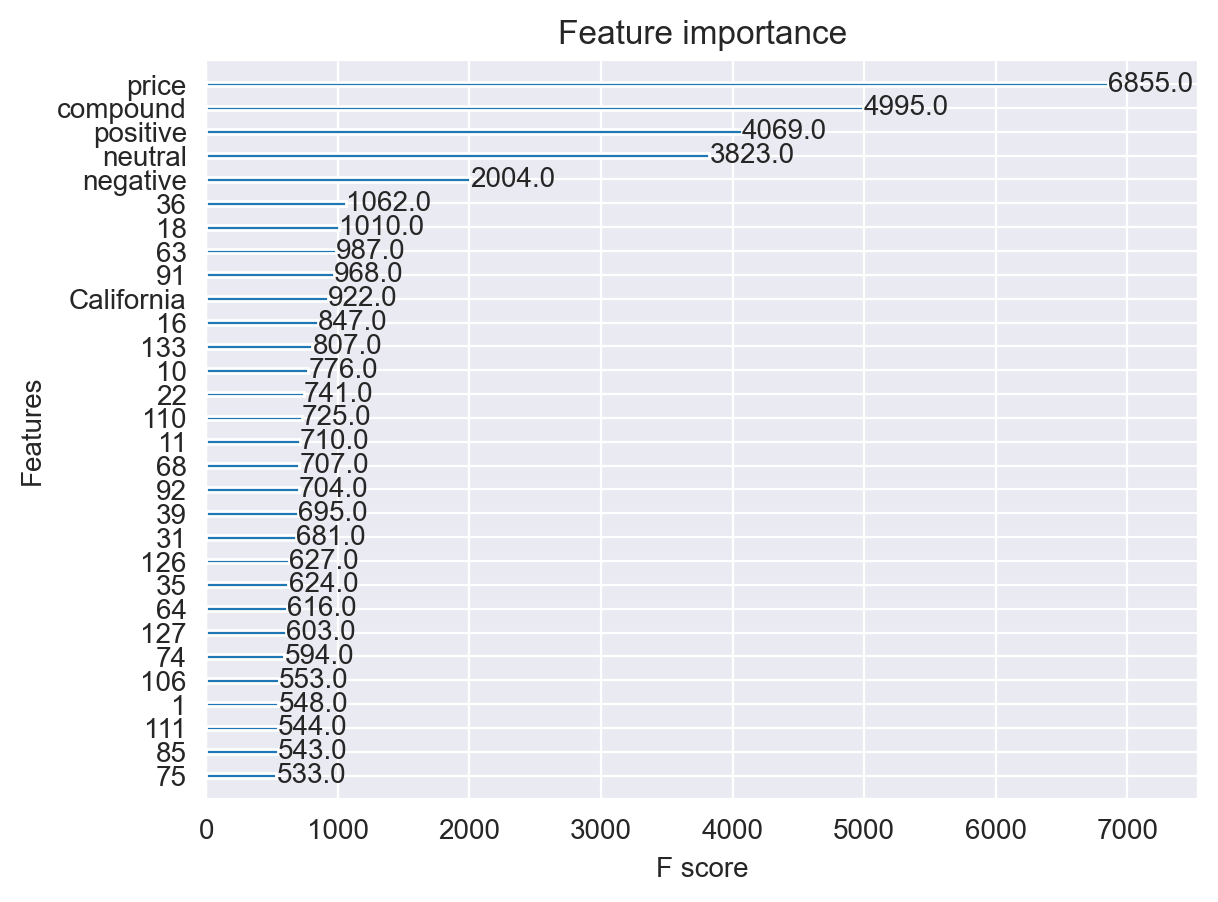

In [6]:
xgb.plot_importance(model_xgb, max_num_features=30)

### 5.2 Graph

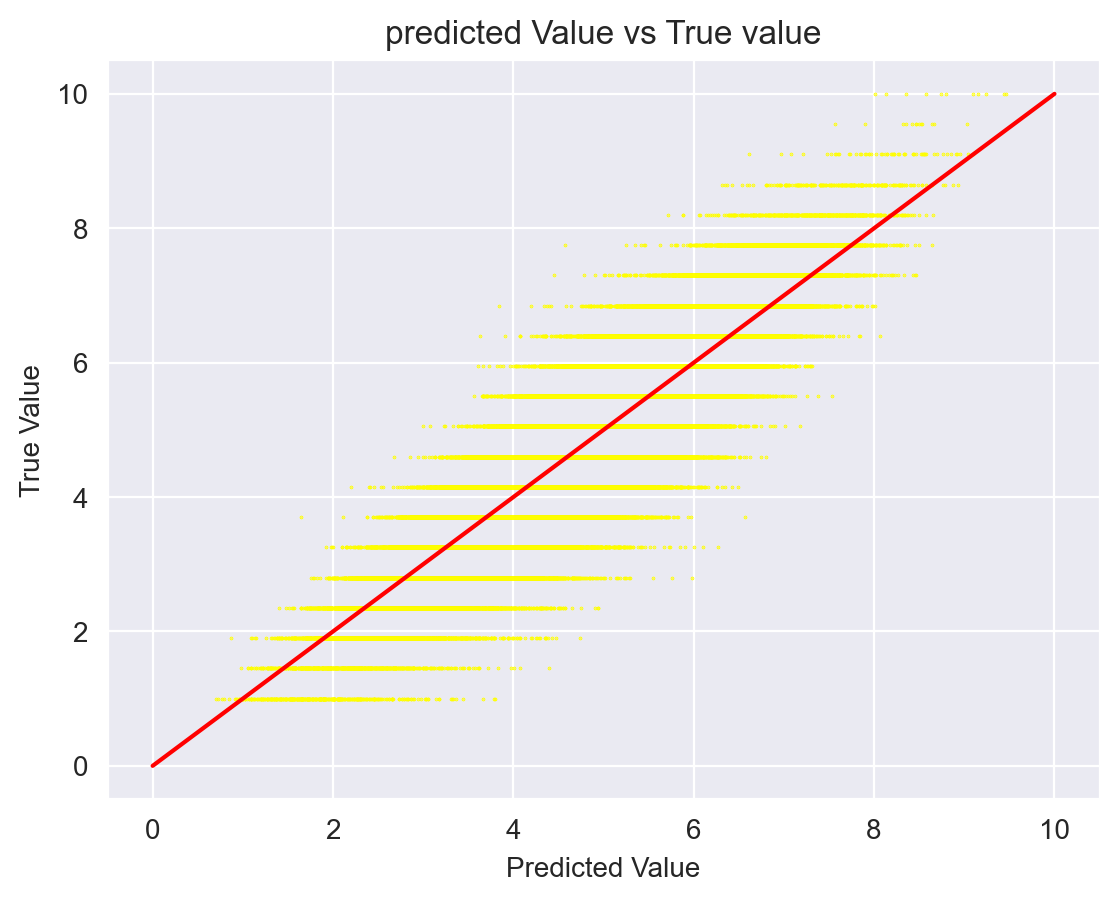

In [63]:
x = np.linspace(0, 10, 100)
predicted_values = model_xgb.predict(X)

fig, ax = plt.subplots()
ax.plot(x, x, color='red')
ax.scatter(predicted_values, y, s=0.1, color='yellow')
ax.set_xlabel('Predicted Value')
ax.set_ylabel('True Value')
ax.set_title('predicted Value vs True value')

plt.show()